Your task is to create an algorithm, that takes an HTML page as input and infers if the page contains the information about cancer tumor board or not.

What is a tumor board? Tumor Board is a consilium of doctors (usually from diferent disciplines) discussing cancer cases in their departments. If you want to know more you can read this article.

As a final output from this task you should provide a submission.csv file for the test data set with two columns: document ID and a prediction, and a Jupyter notebook with code and documentation giving answers to the following questions:

How did you decide to handle this amount of data?
How did you decide to do feature engineering?
How did you decide which models to try (if you decide to train any models)?
How did you perform validation of your model?
What metrics did you measure?
How do you expect your model to perform on test data (in terms of your metrics)?
How fast will your algorithm perform and how could you improve its performance if you would have more time?
How do you think you would be able to improve your algorithm if you would have more data?
What potential issues do you see with your algorithm?

## 1. Load and Preprocess the Data

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

In [226]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, stem_text

In [227]:
# Load Data
train_data = pd.read_csv('./datasets/train.csv')
test_data = pd.read_csv('./datasets/test.csv')
tumor_keywords = pd.read_csv("./datasets/keyword2tumor_type.csv")

In [228]:
train_data.shape

(100, 3)

In [229]:
train_data.groupby("label").size()

label
1    32
2    59
3     9
dtype: int64

In [230]:
test_data = pd.read_csv('./datasets/test.csv')
test_data.head()

,url,doc_id
0,http://chirurgie-goettingen.de/medizinische-ve...,0
1,http://evkb.de/kliniken-zentren/chirurgie/allg...,2
2,http://krebszentrum.kreiskliniken-reutlingen.d...,7
3,http://marienhospital-buer.de/mhb-av-chirurgie...,15
4,http://marienhospital-buer.de/mhb-av-chirurgie...,16


In [231]:
test_data.shape

(48, 2)

In [232]:
tumor_keywords = pd.read_csv("./datasets/keyword2tumor_type.csv")
tumor_keywords.head()

,keyword,tumor_type
0,senologische,Brust
1,brustzentrum,Brust
2,breast,Brust
3,thorax,Brust
4,thorakale,Brust


In [233]:
tumor_keywords.shape

(126, 2)

In [234]:
tumor_keywords["tumor_type"].nunique()

36

In [235]:
tumor_keywords["tumor_type"].unique()

array(['Brust', 'Darm', 'Endokrine malignome',
       'Gallenblasen/gallengangkrebs', 'Gynäkologie', 'Harnblase', 'Haut',
       'Hoden, penis', 'Hämatooncology', 'Kopf-hals', 'Leber', 'Lunge',
       'Lymphom', 'Magen', 'Mamma carcinoma', 'Neuroonkologie', 'Niere',
       'Pankreas', 'Prostata', 'Rare cancer', 'Sarkome', 'Speiseröhre',
       'Urologische', 'Adenoid', 'Adrenal', 'Bauchspeicheldrüsenkrebs',
       'Interdisziplinär', 'Knochentumoren', 'Mikroskopieren',
       'Molekular', 'Oral', 'Prätherapeutische', 'Pädiatrische',
       'Schwerpunkt', 'Stammzelltransplantation', 'Surgical'],
      dtype=object)

- There are 100 documents in the train set
- 48 documents in the test set
- The tumor board labels are distributed as follows:
    - label 1 -> 32 (No Tumor Board mention)
    - label 2 -> 59 (Where Tumor Board is mentioned but not certain if it is the main focus)
    - label 3 -> 9 (The entire document is dedicated to tumor boards)
   

In [236]:
# Read HTML Files
def read_html(doc_id: int) -> str:
    with open(file=f"./datasets/htmls/{doc_id}.html", mode="r", encoding="latin1") as f:
        return f.read()
train_data["html"] = train_data["doc_id"].apply(read_html)

In [237]:
train_data.head()

,url,doc_id,label,html
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1,<!DOCTYPE html>\n<!-- jsn_reta_pro 1.0.2 -->\n...
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3,"<!DOCTYPE html>\n<html class=""no-js"" lang=""de""..."
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<..."
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<..."
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<..."


In [238]:
def extract_text(html):
    soup = BeautifulSoup(html, "lxml")
    for script in soup(["script", "style"]):
        script.decompose()
    return soup.get_text(separator=" ")

train_data["html_text"] = train_data["html"].apply(extract_text)

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



In [239]:
train_data.sample(n=5,random_state=42)

,url,doc_id,label,html,html_text
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_...",\n \n \n \n \n Prostata-Karzinom-Zentrum - Sch...
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me...",\n \n \n \n Darmzentrum Rheinpfalz » Zentren A...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...


In [240]:
def preprocess_text(text):
    text = text.lower()
    text = strip_punctuation(text)
    text = remove_stopwords(text)
    text = stem_text(text)
    return text

train_data["clean_text"] = train_data["html_text"].apply(preprocess_text)

In [241]:
train_data.sample(n=5,random_state=42)

,url,doc_id,label,html,html_text,clean_text
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_...",\n \n \n \n \n Prostata-Karzinom-Zentrum - Sch...,prostata karzinom zentrum schwarzwald baar kli...
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,unser profil gefã¤ã und thoraxchirurgi klinik...
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,maltes kliniken rhein ruhr darmzentrum duisbur...
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me...",\n \n \n \n Darmzentrum Rheinpfalz » Zentren A...,darmzentrum rheinpfalz » zentren z » kliniken ...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,mund kiefer und plastisch gesichtschirurgi en ...


## 2. Exploratory Data Analysis

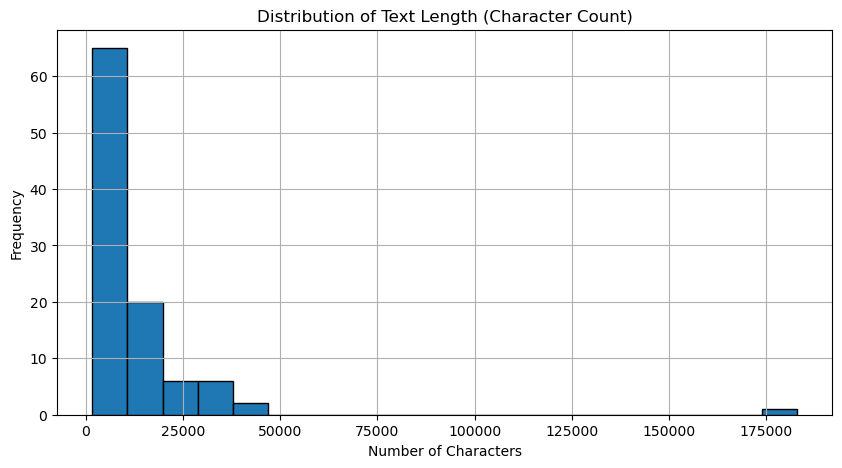

In [242]:
#Check text length distribution
plt.figure(figsize=(10, 5))
plt.hist(train_data["clean_text"].apply(len), bins=20, edgecolor='black')
plt.title("Distribution of Text Length (Character Count)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [243]:
# Create a new DataFrame with text length information
df_filtered = train_data.copy()
df_filtered["text_length"] = df_filtered["clean_text"].apply(lambda x: len(str(x)))  # Convert to string if needed

# Filter documents with text length greater than 170000
long_text_docs = df_filtered[df_filtered["text_length"] > 170000]

# Display count
print("Number of documents with text length > 170000:", len(long_text_docs))

# Display the first few rows for verification
long_text_docs.head()

Number of documents with text length > 170000: 1


,url,doc_id,label,html,html_text,clean_text,text_length
95,http://www.unicross.uni-freiburg.de/thema/unifm/,140,1,"<!DOCTYPE html>\n<html lang=""de-DE""\nprefix=""o...",\n \n \n \n \n \n \n \n \n \n \n uniFM | uniCR...,unifm unicross new magazin theme home wir mach...,182823


**There is one document with 170-179K characters. Others are with < 50K character count in total.**

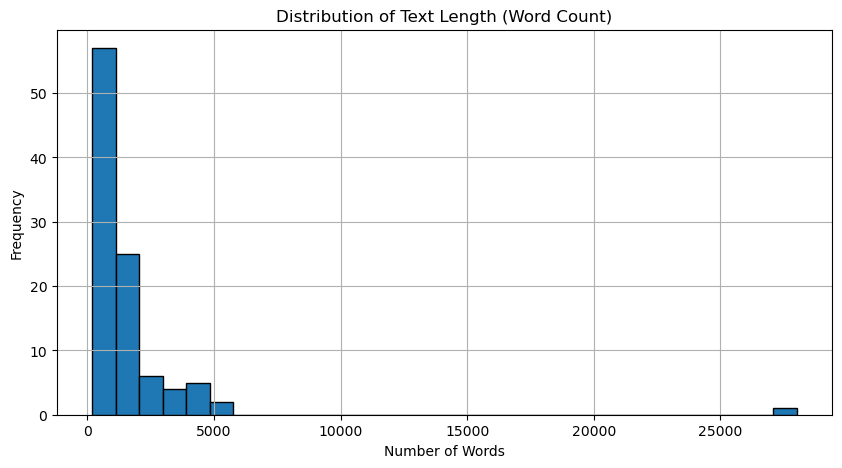

In [244]:
#Check word count distribution
plt.figure(figsize=(10, 5))
plt.hist(train_data["clean_text"].apply(lambda x: len(x.split())), bins=30, edgecolor='black')
plt.title("Distribution of Text Length (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [245]:
# Create a new DataFrame for word count analysis
df_word_count = train_data.copy()

# Calculate word count for each document
df_word_count["word_count"] = df_word_count["clean_text"].apply(lambda x: len(str(x).split()))

# Filter documents with word count greater than 20,000
long_text_docs_words = df_word_count[df_word_count["word_count"] > 20000]

# Display count
print("Number of documents with word count > 20000:", len(long_text_docs_words))

# Display first few rows for verification
long_text_docs_words.head()


Number of documents with word count > 20000: 1


,url,doc_id,label,html,html_text,clean_text,word_count
95,http://www.unicross.uni-freiburg.de/thema/unifm/,140,1,"<!DOCTYPE html>\n<html lang=""de-DE""\nprefix=""o...",\n \n \n \n \n \n \n \n \n \n \n uniFM | uniCR...,unifm unicross new magazin theme home wir mach...,28017


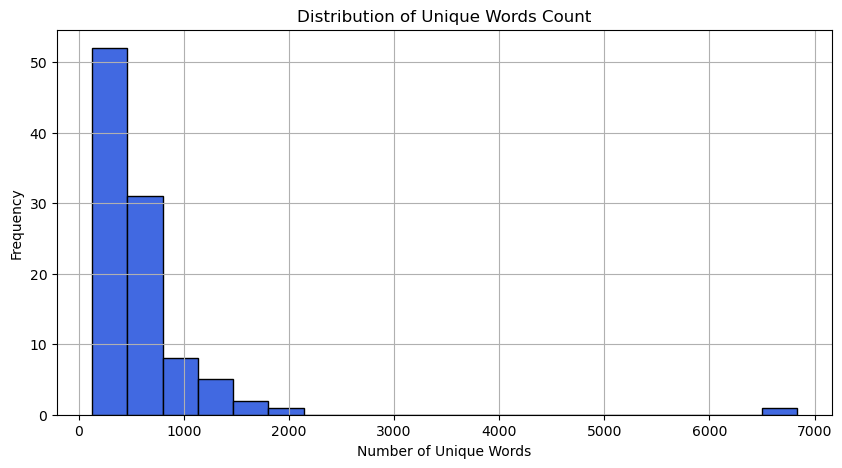

In [246]:
# Calculate unique word count for each document
unique_word_counts = train_data["clean_text"].apply(lambda text: len(set(text.split())))

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(unique_word_counts, bins=20, edgecolor='black', color='royalblue')
plt.title("Distribution of Unique Words Count")
plt.xlabel("Number of Unique Words")
plt.ylabel("Frequency")
plt.grid(True)

# Save and display the plot
plt.savefig("unique_word_count_distribution.png")
plt.show()

**There is one document with 6500-7000 unique words. All others consist of < 2000 unique words.**

## 3.MODELLING

In [247]:
# Feature Engineering - TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(train_data["clean_text"])
y = train_data["label"]

In [248]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [249]:
# Train and Evaluate Multiple Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naïve Bayes (ComplementNB)": ComplementNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', probability=True)
}

Training Logistic Regression...
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.50      0.90      0.64        10
           3       0.00      0.00      0.00         3

    accuracy                           0.45        20
   macro avg       0.17      0.30      0.21        20
weighted avg       0.25      0.45      0.32        20



/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



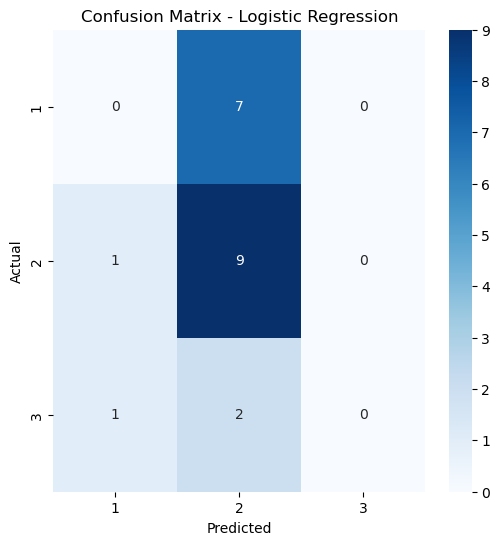

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



Training Naïve Bayes (ComplementNB)...
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.50      0.90      0.64        10
           3       0.00      0.00      0.00         3

    accuracy                           0.45        20
   macro avg       0.17      0.30      0.21        20
weighted avg       0.25      0.45      0.32        20



/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



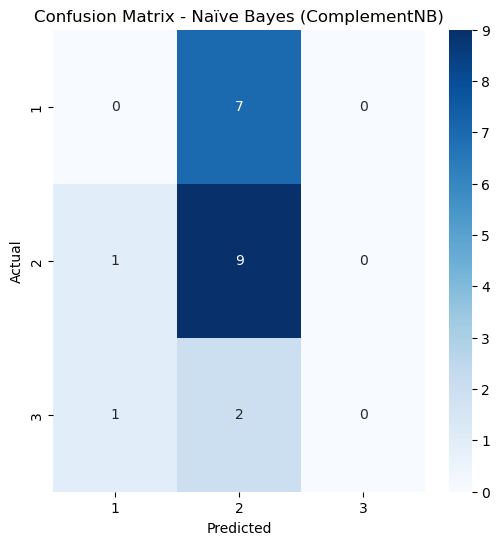

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



Training Random Forest...
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.47      0.90      0.62        10
           3       0.00      0.00      0.00         3

    accuracy                           0.45        20
   macro avg       0.16      0.30      0.21        20
weighted avg       0.24      0.45      0.31        20



/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



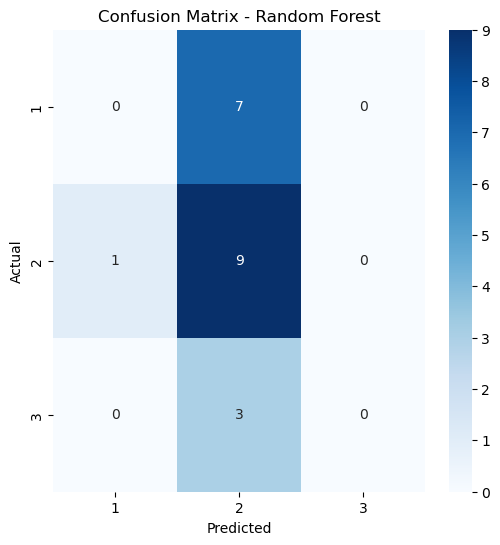

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



Training Support Vector Machine...
Accuracy: 0.4
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.47      0.80      0.59        10
           3       0.00      0.00      0.00         3

    accuracy                           0.40        20
   macro avg       0.16      0.27      0.20        20
weighted avg       0.24      0.40      0.30        20



/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



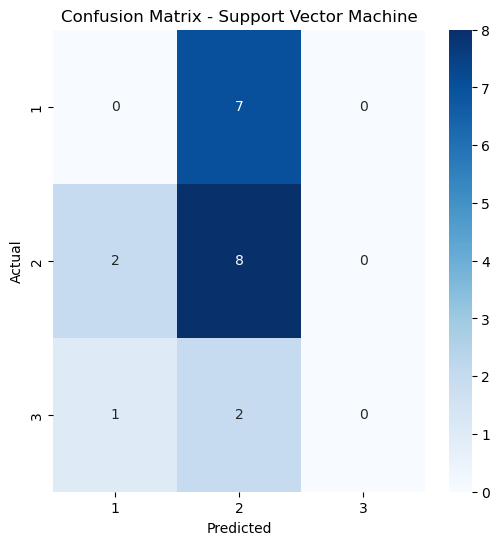

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



In [250]:
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc
    print(f"Accuracy: {acc}")
    print("Classification Report:\n", classification_report(y_val, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3], yticklabels=[1,2,3])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    # Process Test Data
    test_data["html"] = test_data["doc_id"].apply(read_html)
    test_data["html_text"] = test_data["html"].apply(extract_text)
    test_data["clean_text"] = test_data["html_text"].apply(preprocess_text)
    X_test = tfidf_vectorizer.transform(test_data["clean_text"])
    
    # Make Predictions using the model
    test_predictions = model.predict(X_test)
    submission = pd.DataFrame({"document_id": test_data["doc_id"], "prediction": test_predictions})
    submission.to_csv(f"{name.replace(' ', '_')}_submission.csv", index=False)


In [251]:
# Select Best Model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name} with accuracy {results[best_model_name]}")


Best Model: Logistic Regression with accuracy 0.45


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, stem_text

# Load Data
train_data = pd.read_csv('./datasets/train.csv')
test_data = pd.read_csv('./datasets/test.csv')
tumor_keywords = pd.read_csv("./datasets/keyword2tumor_type.csv")

# Read HTML Files
def read_html(doc_id: int) -> str:
    with open(file=f"./datasets/htmls/{doc_id}.html", mode="r", encoding="latin1") as f:
        return f.read()

train_data["html"] = train_data["doc_id"].apply(read_html)

def extract_text(html):
    soup = BeautifulSoup(html, "lxml")
    for script in soup(["script", "style"]):
        script.decompose()
    return soup.get_text(separator=" ")

train_data["html_text"] = train_data["html"].apply(extract_text)

def preprocess_text(text):
    text = text.lower()
    text = strip_punctuation(text)
    text = remove_stopwords(text)
    text = stem_text(text)
    return text

train_data["clean_text"] = train_data["html_text"].apply(preprocess_text)

# Feature Engineering - TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(train_data["clean_text"])
y = train_data["label"]

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and Evaluate Multiple Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naïve Bayes (ComplementNB)": ComplementNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', probability=True),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



Training Logistic Regression...
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.50      0.90      0.64        10
           3       0.00      0.00      0.00         3

    accuracy                           0.45        20
   macro avg       0.17      0.30      0.21        20
weighted avg       0.25      0.45      0.32        20



/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



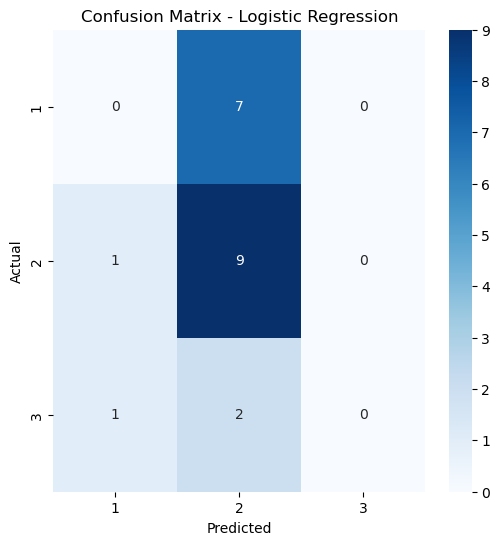

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



Training Naïve Bayes (ComplementNB)...
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.50      0.90      0.64        10
           3       0.00      0.00      0.00         3

    accuracy                           0.45        20
   macro avg       0.17      0.30      0.21        20
weighted avg       0.25      0.45      0.32        20



/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



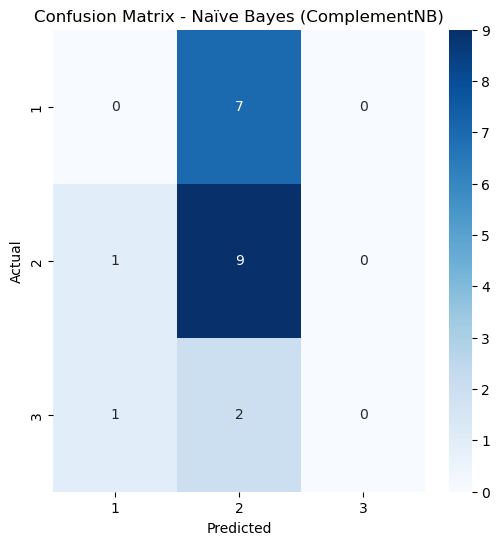

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



Training Random Forest...
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.47      0.90      0.62        10
           3       0.00      0.00      0.00         3

    accuracy                           0.45        20
   macro avg       0.16      0.30      0.21        20
weighted avg       0.24      0.45      0.31        20



/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



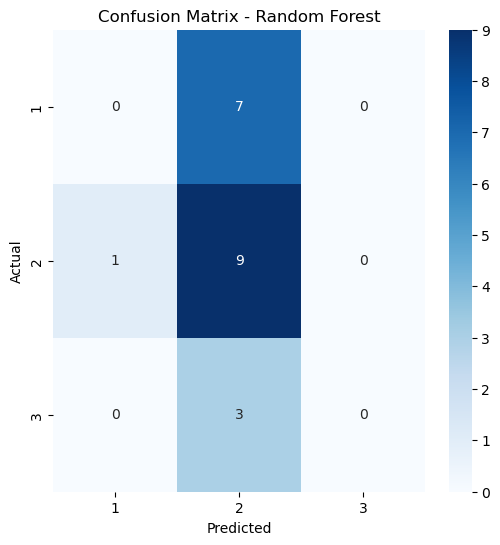

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



Training Support Vector Machine...
Accuracy: 0.4
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.47      0.80      0.59        10
           3       0.00      0.00      0.00         3

    accuracy                           0.40        20
   macro avg       0.16      0.27      0.20        20
weighted avg       0.24      0.40      0.30        20



/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/senin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



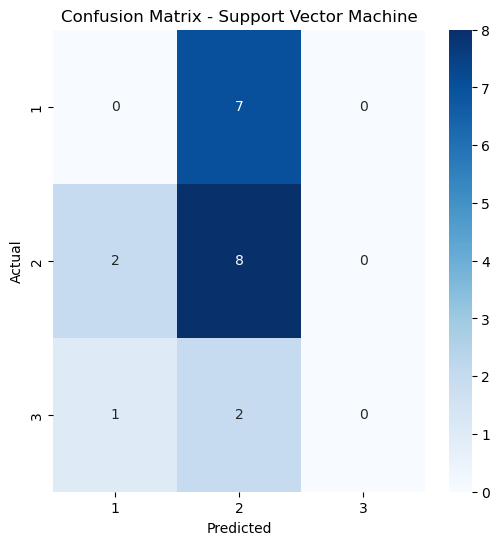

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



Training Gradient Boosting...
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.56      0.90      0.69        10
           3       0.00      0.00      0.00         3

    accuracy                           0.45        20
   macro avg       0.19      0.30      0.23        20
weighted avg       0.28      0.45      0.35        20



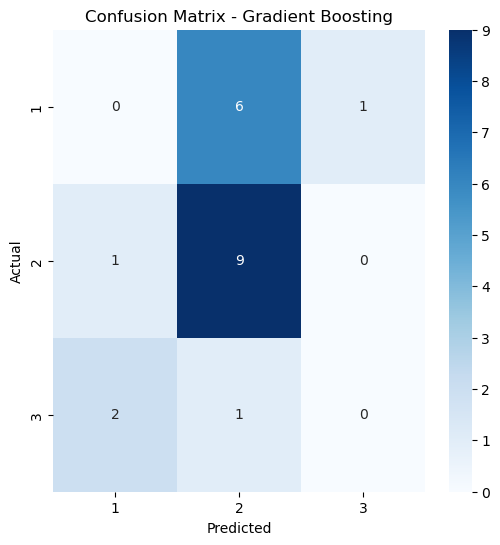

/Users/senin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



Best Model: Logistic Regression with accuracy 0.45


In [252]:
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc
    print(f"Accuracy: {acc}")
    print("Classification Report:\n", classification_report(y_val, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3], yticklabels=[1,2,3])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    # Process Test Data
    test_data["html"] = test_data["doc_id"].apply(read_html)
    test_data["html_text"] = test_data["html"].apply(extract_text)
    test_data["clean_text"] = test_data["html_text"].apply(preprocess_text)
    X_test = tfidf_vectorizer.transform(test_data["clean_text"])
    
    # Make Predictions using the model
    test_predictions = model.predict(X_test)
    submission = pd.DataFrame({"document_id": test_data["doc_id"], "prediction": test_predictions})
    submission.to_csv(f"{name.replace(' ', '_')}_submission.csv", index=False)

# Select Best Model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name} with accuracy {results[best_model_name]}")